<a href="https://colab.research.google.com/github/anandman03/movie-recommendation-system/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Recommendation System is a filtration program whose prime goal is to predict the “rating” or “preference” of a user towards a domain-specific item or item.

1. Content-based Filtering
    - User can have multiple interests.
    - Never recommends items outside user's content profile.
    - Finding the appropriate feature is hard like - genre, music or cast etc.
    - Never recommend popular/trending movies like squid game based on user data.
    - Cold start problem for new users.

2. User Based Collaborative filtering
    - Users can change their taste from time to time.
    - Requires heavy computations as user set could he huge.
    - shilling attacks where fake users profiles consisting of biased preference patterns are used to manipulate key decisions.

Based on problems occured from other approaches, using Item based Collaborative filtering.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [3]:
movies.head(5)

movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]

In [4]:
ratings.head(5)

userId  movieId  rating    timestamp
0       1        1     4.0  964982703.0
1       1        3     4.0  964981247.0
2       1        6     4.0  964982224.0
3       1       47     5.0  964983815.0
4       1       50     5.0  964982931.0

In [5]:
final_dataset = ratings.pivot(index='movieId', columns='userId', values='rating')
final_dataset.head()

userId   1    2    3    4    5    6    7    ...  282  283  284  285  286  287  288
movieId                                     ...                                   
1        4.0  NaN  NaN  NaN  4.0  NaN  4.5  ...  4.5  3.0  NaN  NaN  NaN  NaN  4.5
2        NaN  NaN  NaN  NaN  NaN  4.0  NaN  ...  NaN  NaN  4.0  NaN  NaN  NaN  2.0
3        4.0  NaN  NaN  NaN  NaN  5.0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  4.0
4        NaN  NaN  NaN  NaN  NaN  3.0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN
5        NaN  NaN  NaN  NaN  NaN  5.0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  2.0

[5 rows x 288 columns]

In [6]:
final_dataset.fillna(0, inplace=True)
final_dataset.head()

userId   1    2    3    4    5    6    7    ...  282  283  284  285  286  287  288
movieId                                     ...                                   
1        4.0  0.0  0.0  0.0  4.0  0.0  4.5  ...  4.5  3.0  0.0  0.0  0.0  0.0  4.5
2        0.0  0.0  0.0  0.0  0.0  4.0  0.0  ...  0.0  0.0  4.0  0.0  0.0  0.0  2.0
3        4.0  0.0  0.0  0.0  0.0  5.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  4.0
4        0.0  0.0  0.0  0.0  0.0  3.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5        0.0  0.0  0.0  0.0  0.0  5.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  2.0

[5 rows x 288 columns]

In a real world, ratings are very sparse and data points are mostly collected from very popular movies and highly engaged users. So we will reduce the noise by adding some filters and qualify the movies for the final dataset.

- To qualify a movie, minimum 10 users should have voted a movie.
- To qualify a user, minimum 50 movies should have voted by the user.

In [13]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

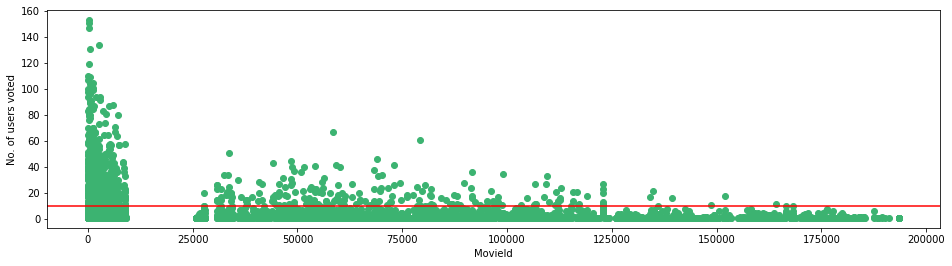

In [8]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [9]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]

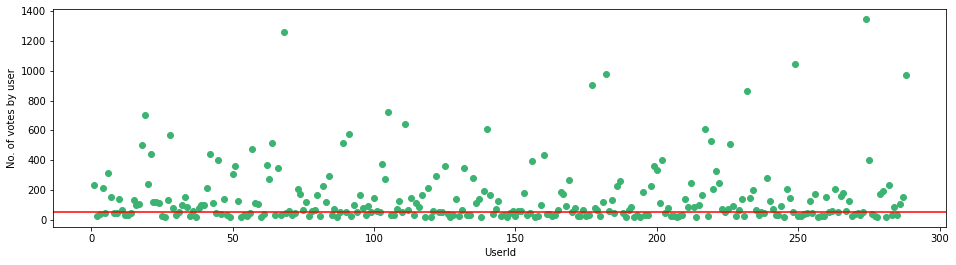

In [10]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [11]:
final_dataset = final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset

userId   1    4    6    7    10   11   15   ...  279  280  282  284  286  287  288
movieId                                     ...                                   
1        4.0  0.0  0.0  4.5  0.0  0.0  2.5  ...  3.0  4.5  4.5  0.0  0.0  0.0  4.5
2        0.0  0.0  4.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  4.0  0.0  0.0  2.0
3        4.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  4.0
5        0.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  2.0
6        4.0  0.0  4.0  0.0  0.0  5.0  0.0  ...  0.0  0.0  4.0  0.0  4.5  0.0  0.0
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
134853   0.0  0.0  0.0  0.0  0.0  0.0  4.5  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
139385   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  5.0  0.0  4.5  0.0  0.0  0.0  0.0
148626   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  3.5  0.0  0.0  0.0  0.0  0.0  0.0
152081   0.0  0.0  0.0  0.0  0.0  0.0  3.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
164179   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  4.0  0.0  0.0  0.0  0.0  0.0  0.0

[1078 rows x 178 columns]

Removing sparsity

In [14]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)
final_dataset

userId  movieId    1    4    6    7   10  ...  280  282  284  286  287  288
0             1  4.0  0.0  0.0  4.5  0.0  ...  4.5  4.5  0.0  0.0  0.0  4.5
1             2  0.0  0.0  4.0  0.0  0.0  ...  0.0  0.0  4.0  0.0  0.0  2.0
2             3  4.0  0.0  5.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  4.0
3             5  0.0  0.0  5.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  2.0
4             6  4.0  0.0  4.0  0.0  0.0  ...  0.0  4.0  0.0  4.5  0.0  0.0
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
1073     134853  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
1074     139385  0.0  0.0  0.0  0.0  0.0  ...  0.0  4.5  0.0  0.0  0.0  0.0
1075     148626  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
1076     152081  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
1077     164179  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0

[1078 rows x 179 columns]

We use cosine distance metric which is very fast and preferable than pearson coefficient. Please don't use euclidean distance which will not work when the values are equidistant.

In [15]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [18]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]

    if len(movie_list):
        movie_idx = movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        
        distances, indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})

        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    
    else:    
        return "No movies found. Please check your input"

In [19]:
get_movie_recommendation('Iron Man')

Title  Distance
1                                       Avatar (2009)  0.376432
2   Pirates of the Caribbean: Dead Man's Chest (2006)  0.375242
3                          Lucky Number Slevin (2006)  0.369508
4                      Matrix Revolutions, The (2003)  0.357778
5                                Avengers, The (2012)  0.345033
6                                Batman Begins (2005)  0.337292
7                        Bourne Ultimatum, The (2007)  0.335450
8     Pirates of the Caribbean: At World's End (2007)  0.312556
9                                     Watchmen (2009)  0.310896
10                            Dark Knight, The (2008)  0.282547